In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import seaborn as sns
import time

from emd import emd
from kde.location_project.cmp import geodesic_dist
# from kde.location_project.kde_2d import kdnearest

sys.setrecursionlimit(10000)

%matplotlib inline
init_notebook_mode(connected=True)

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None # turn off SettingWithCopyWarning

np.random.seed(1234)
time_span = 'month'
n_visits = 1

# Geolocation Data - Twitter

NOTE: all of the results in the paper discussed B as fixed, but in this analysis A is fixed.

In [2]:
### NY
ny_directory = os.path.join("..", "data", "ny") 
ny = pd.read_csv(os.path.join(ny_directory, "visits_no_filter.csv"))
ny_deduped = pd.read_csv(os.path.join(ny_directory, "visits_deduped.csv"))
mpp = pd.read_csv(os.path.join(ny_directory, "mpp_visits_month0a_month1b_n1.csv"))

print("Days:", ny['day_id'].nunique())
print("Accounts:", ny['user_id'].nunique())
print("Events: ", ny.shape[0], " (", round(ny.shape[0] / ny['user_id'].nunique(), 1), ")",sep="")
print("Visits: ", ny_deduped.shape[0], " (", round(ny_deduped.shape[0] / ny['user_id'].nunique(), 1), ")",sep="")
print("")
print("MPP DATA (at least {} visits in each of the first two {}s)".format(n_visits, time_span))
print("Users:", mpp['uid'].nunique())
print("Visits: ", len(mpp), " (", round(len(mpp) / mpp['uid'].nunique(), 1), ")",sep="")
ind_A = mpp.m == 'a'
print("n_A: ", len(mpp.loc[ind_A]), " (", round(len(mpp.loc[ind_A]) / mpp['uid'].nunique(), 1), ")",sep="")
ind_B = mpp.m == 'b'
print("n_B: ", len(mpp.loc[ind_B]), " (", round(len(mpp.loc[ind_B]) / mpp['uid'].nunique(), 1), ")",sep="")


Days: 239
Accounts: 194224
Events: 1162871 (6.0)
Visits: 989494 (5.1)

MPP DATA (at least 1 visits in each of the first two months)
Users: 13523
Visits: 138651 (10.3)
n_A: 72799 (5.4)
n_B: 65852 (4.9)


In [3]:
# location weights based on number of visits
ny_locs = ny_deduped.groupby('location_id')['event_id'].count()
ny_wt_e = pd.DataFrame(ny_locs).reset_index().rename(columns={'event_id': 'weight'})
ny_wt_e['weight'] = 1 / ny_wt_e['weight']

# location weights based on number of unique users at lnyation
ny_locs_users = ny_deduped.groupby(['location_id'])['old_uid'].nunique()
ny_wt_u = pd.DataFrame(ny_locs_users).reset_index().rename(columns={'old_uid': 'weight'})
ny_wt_u['weight'] = 1 / ny_wt_u['weight']

# merge weights in to the point pattern data
ny_deduped = pd.merge(ny_deduped, ny_wt_e, on='location_id')
ny_deduped = pd.merge(ny_deduped, ny_wt_u, on='location_id', suffixes=('_event', '_user'))
ny_deduped.head()

,old_uid,uid,lon,lat,location_id,visit,month,event_id,weight_event,weight_user
0,22.0,-1.0,-73.99706,40.73597,23615.0,0,6,6101502.0,0.003378,0.004587
1,8881.0,-1.0,-73.99706,40.73597,23615.0,0,4,2173506.0,0.003378,0.004587
2,705663.0,-1.0,-73.99706,40.73597,23615.0,0,0,11273583.0,0.003378,0.004587
3,754812.0,-1.0,-73.99706,40.73597,23615.0,0,4,5511985.0,0.003378,0.004587
4,1938691.0,-1.0,-73.99706,40.73597,23615.0,26,5,7998685.0,0.003378,0.004587


In [4]:
# merge weights in to the point pattern data
mpp = pd.merge(mpp, ny_wt_e, on='location_id')
mpp = pd.merge(mpp, ny_wt_u, on='location_id', suffixes=('_event', '_user'))
mpp.head()

,old_uid,uid,m,lon,lat,location_id,weight_event,weight_user
0,418.0,1,a,-73.99384,40.72405,4962.0,0.003774,0.004237
1,418.0,1,a,-73.99384,40.72405,4962.0,0.003774,0.004237
2,418.0,1,b,-73.99384,40.72405,4962.0,0.003774,0.004237
3,418.0,1,b,-73.99384,40.72405,4962.0,0.003774,0.004237
4,15455345.0,754,b,-73.99383,40.72408,4962.0,0.003774,0.004237


# Create necessary data for experiments

## Population KDE

In [5]:
from kde.location_project.kde_2d import (
    KDE,
    MixtureKDE,
    create_individual_component_data,
    learn_nearest_neighbors_bandwidth
)

# learn the bandwidth for each point & save to file (it's expensive)
filepath = os.path.join("..", "data", "DFRWS_USA", "ny", "population_visits_kde_data.npy")

# points = ny_deduped.loc[:, ['lon', 'lat']].values
# bw_pop = learn_nearest_neighbors_bandwidth(points, k=5, min_bw=0.05)
# kde_data = np.hstack([points, np.atleast_2d(bw_pop).T])  # adaptive bandwidth
# kde_data = np.append(kde_data, np.ones((len(kde_data), 1)), 1)  # equal weights by default
# np.save(filepath, kde_data)

pop_kde_data = np.load(filepath)
pop_kde_data.shape

(989494, 4)

## Stratified Sample

In [6]:
import itertools 
np.random.seed(1234)
splits = [1, 2, 20, float("inf")]

# create all pairwise combinations
ids = mpp.uid.unique()
samp_space = pd.DataFrame(itertools.product(ids, ids), columns=["a", "b"])

# merge in counts of events in A
cts = mpp.groupby(['uid', 'm']).count().reset_index()
cts = cts.loc[cts.m == 'a', ]
cts = cts.rename(columns={"old_uid": "n_a"})
cts.n_a.describe()
samp_space = pd.merge(samp_space, cts[['uid', 'n_a']], left_on='a', right_on='uid').drop(columns="uid")

# merge in counts of events in B
cts = mpp.groupby(['uid', 'm']).count().reset_index()
cts = cts.loc[cts.m == 'b', ]
cts = cts.rename(columns={"old_uid": "n_b"})
cts.n_b.describe()
samp_space = pd.merge(samp_space, cts[['uid', 'n_b']], left_on='b', right_on='uid').drop(columns="uid")

# bin the number of events in A and B for stratified sampling
samp_space['bin_a'] = pd.cut(samp_space.n_a, bins=splits, right=False)
samp_space['bin_b'] = pd.cut(samp_space.n_b, bins=splits, right=False)

# sample 1000 pairs per combination of bins
sample = samp_space.loc[samp_space.a != samp_space.b,].groupby(['bin_a', 'bin_b']).apply(lambda x: x.sample(1000))
sample.index = sample.index.droplevel(0)
sample.index = sample.index.droplevel(0)

# add in same-source pairs
sample = pd.concat([samp_space.loc[samp_space.a == samp_space.b,], sample], sort=True).reset_index(drop=True)

# sample properties
sample.groupby(['bin_a', 'bin_b'])['a'].count()


bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     3421
             [2.0, 20.0)    3060
             [20.0, inf)    1013
[2.0, 20.0)  [1.0, 2.0)     3567
             [2.0, 20.0)    6816
             [20.0, inf)    1156
[20.0, inf)  [1.0, 2.0)     1021
             [2.0, 20.0)    1218
             [20.0, inf)    1251
Name: a, dtype: int64

## Score function values for the sample

In [7]:
# from emd import emd
# from kde.location_project.cmp import geodesic_dist


# def get_user(mpp, uid, mark):
#     out = mpp.copy()
#     # out = out.drop_duplicates(subset=["location_id", "m"])
#     return out.loc[(out.uid == uid) & (out.m == mark)].reset_index(drop=True)


# def population_scores(mpp, keeps):
#     rslt = []    
#     for index, row in keeps.iterrows():
#         user_A = row["a"]
#         user_B = row["b"]
#         tmp = {}
#         try:
#             ### get the data for the pair in question
#             tmp['a'] = user_A
#             tmp['b'] = user_B
#             uA = get_user(mpp, user_A, 'a')
#             uB = get_user(mpp, user_B, 'b')

#             ### compute weights
#             uA_wt_e = (uA['weight_event'] / sum(uA['weight_event'])).to_numpy()
#             uA_wt_u = (uA['weight_user'] / sum(uA['weight_user'])).to_numpy()
#             uB_wt_e = (uB['weight_event'] / sum(uB['weight_event'])).to_numpy()
#             uB_wt_u = (uB['weight_user'] / sum(uB['weight_user'])).to_numpy()

#             ### compute the distance matrix & IED scores
#             dist = geodesic_dist(uA[['lat', 'lon']], uB[['lat', 'lon']])
#             ied = dist.min(1)
#             tmp['ied_med'] = np.median(ied)
#             tmp['ied_mn'] = np.average(ied)
#             tmp['ied_mn_wt_event'] = np.average(ied, weights=uA_wt_e)
#             tmp['ied_mn_wt_user'] = np.average(ied, weights=uA_wt_u)

#             ### compute variants of EMD
#             tmp['emd'] = emd(distance="precomputed", D=dist)
#             tmp['emd_wt_event'] = emd(
#                 X_weights=uA_wt_e, Y_weights=uB_wt_e, distance="precomputed", D=dist
#             )
#             tmp['emd_wt_user'] = emd(
#                 X_weights=uA_wt_u, Y_weights=uB_wt_u, distance="precomputed", D=dist
#             )

#             ### store it
#             rslt.append(tmp)
#         except:
#             print(f"Error! A = {user_A}, B = {user_B}")
#             continue
#     return pd.DataFrame(rslt)

# directory = os.path.join("..", "data", "DFRWS_USA", "ny")
# ny_rslt = population_scores(mpp, sample)
# ny_rslt.to_csv(os.path.join(directory, "score_func_vals.csv"), index=False)

In [10]:
directory = os.path.join("..", "data", "DFRWS_USA", "ny")
ny_rslt = pd.read_csv(os.path.join(directory, "score_func_vals.csv"))
ny_rslt

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user
0,1,1,1.073439,3.514420,2.282388,1.890170,3.639262,2.511669,2.309186
1,754,754,0.000000,0.082594,0.012435,0.001714,10.621138,2.701960,0.217977
2,914,914,1.285994,1.170474,1.296949,1.307994,1.894247,4.340711,4.323836
3,963,963,0.304149,0.457392,0.664379,0.690030,1.756811,1.373963,1.453024
4,1398,1398,0.001395,0.294026,0.083932,0.069981,0.294026,0.083932,0.069981
...,...,...,...,...,...,...,...,...,...
22518,4060,9441,1.161314,0.959781,1.088293,1.115413,3.246198,2.830677,2.978483
22519,7534,11463,15.644413,12.690486,12.911996,14.391071,15.195952,16.323192,17.836107
22520,10051,2784,3.571658,2.659750,2.241595,2.339622,3.095235,2.742689,2.757518
22521,13401,6021,1.342960,1.293657,1.182785,1.233621,3.147209,2.573242,3.251477


# Analyze Results

In [9]:
from sklearn.metrics import roc_auc_score

def perf_measure(y_actual, y_hat):
    y_actual = list(y_actual)
    y_hat = list(y_hat)

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)
    
    return (format(round(tpr, 3), '.3f'), format(round(fpr, 3), '.3f'))


def calc_auc(rslt, score, column='label'):
    return format(round(roc_auc_score(rslt[column], rslt[score]), 3), '.3f')


def slr_classifier_performance_for_tex(rslt):
    print("& Weights & $\Delta$ &  TP@1  & FP@1  & AUC \\\\")
    print("\\hline")
    print(
        "& Account & $\mean{D}_{min}$ & ",
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_mn_wt_user'] > 1)), "&", 
        calc_auc(rslt,'ied_mn_wt_user'), "\\\\"
    )
    print(
        "& Account & EMD    & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['emd_wt_user'] > 1)), "&", 
        calc_auc(rslt,'emd_wt_user'), "\\\\"
    )
    print(
        "& Uniform & $\mean{D}_{min}$ & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_mn'] > 1)), "&", 
        calc_auc(rslt,'ied_mn'), "\\\\"
    ) 
    print(
        "& Uniform & EMD     & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['emd'] > 1)), "&", 
        calc_auc(rslt,'emd'), "\\\\"
    )
    print(
        "& Visit   & $\mean{D}_{min}$ & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_mn_wt_event'] > 1)), "&", 
        calc_auc(rslt,'ied_mn_wt_event'), "\\\\"
    )
    print(
        "& Visit   & EMD      & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['emd_wt_event'] > 1)), "&", 
        calc_auc(rslt,'emd_wt_event'), "\\\\"
    )


def cmp_classifier_performance_for_tex(rslt):
    print("& $\Delta$ & Weights & TP@0.05  & TP@0.01 & AUC    ")
    print("\\hline")
    print(
        "& Account & $\mean{D}_{min}$ & ",
        perf_measure(~rslt['label'], rslt['ied_mn_wt_user'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['ied_mn_wt_user'] < 0.01)[0], "  &",
        calc_auc(rslt,'ied_mn_wt_user'), "\\\\"
    )
    print(
        "& Account & EMD & ",
        perf_measure(~rslt['label'], rslt['emd_wt_user'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['emd_wt_user'] < 0.01)[0], "  &",
        calc_auc(rslt,'emd_wt_user'), "\\\\"
    )
    print(
        "& Uniform & $\mean{D}_{min}$ & ", 
        perf_measure(~rslt['label'], rslt['ied_mn'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['ied_mn'] < 0.01)[0], "  &",
        calc_auc(rslt,'ied_mn'), "\\\\"
    ) 
    print(
        "& Uniform & EMD & ", 
        perf_measure(~rslt['label'], rslt['emd'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['emd'] < 0.01)[0], "  &",
        calc_auc(rslt,'emd'), "\\\\"
    )
    print(
        "& Visit   & $\mean{D}_{min}$ & ", 
        perf_measure(~rslt['label'], rslt['ied_mn_wt_event'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['ied_mn_wt_event'] < 0.01)[0], "  &",
        calc_auc(rslt,'ied_mn_wt_event'), "\\\\"
    )
    print(
        "& Visit   & EMD & ", 
        perf_measure(~rslt['label'], rslt['emd_wt_event'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['emd_wt_event'] < 0.01)[0], "  &",
        calc_auc(rslt,'emd_wt_event'), "\\\\"
    )

In [29]:
directory = os.path.join("..", "data", "DFRWS_USA", "ny")
slr = pd.read_csv(os.path.join(directory, "slr.csv"))
cmp = pd.read_csv(os.path.join(directory, "cmp.csv"))
lr = pd.read_csv(os.path.join(directory, "lr.csv"))

slr["same-src"] = (slr.a == slr.b).astype(bool)
cmp["same-src"] = (cmp.a == cmp.b).astype(bool)
lr["same-src"] = (lr.a == lr.b).astype(bool)

In [30]:
print("TP/FP@1", perf_measure(lr['same-src'], lr['lr_alpha_vary'] >= 0))
print("AUC", calc_auc(lr, 'lr_alpha_vary', 'same-src'))

TP/FP@1 ('0.380', '0.038')
AUC 0.845


In [31]:
print("TP/FP@1", perf_measure(lr['same-src'], lr['lr_alpha_80'] >= 0))
print("AUC", calc_auc(lr, 'lr_alpha_80', 'same-src'))

TP/FP@1 ('0.340', '0.026')
AUC 0.787


In [32]:
slr['label'] = (slr.a == slr.b).astype(bool)  # same-src has larger slr
slr_classifier_performance_for_tex(slr)

& Weights & $\Delta$ &  TP@1  & FP@1  & AUC \\
\hline
& Account & $\mean{D}_{min}$ &  0.610 & 0.171 & 0.774 \\
& Account & EMD    &  0.614 & 0.162 & 0.783 \\
& Uniform & $\mean{D}_{min}$ &  0.628 & 0.202 & 0.768 \\
& Uniform & EMD     &  0.654 & 0.197 & 0.790 \\
& Visit   & $\mean{D}_{min}$ &  0.611 & 0.180 & 0.768 \\
& Visit   & EMD      &  0.602 & 0.169 & 0.774 \\


In [33]:
cmp['label'] = (cmp.a != cmp.b).astype(bool)  # same-src has larger slr
cmp_classifier_performance_for_tex(cmp)

& $\Delta$ & Weights & TP@0.05  & TP@0.01 & AUC    
\hline
& Account & $\mean{D}_{min}$ &  0.441   & 0.236   & 0.776 \\
& Account & EMD &  0.448   & 0.208   & 0.784 \\
& Uniform & $\mean{D}_{min}$ &  0.389   & 0.187   & 0.771 \\
& Uniform & EMD &  0.397   & 0.154   & 0.791 \\
& Visit   & $\mean{D}_{min}$ &  0.415   & 0.209   & 0.771 \\
& Visit   & EMD &  0.425   & 0.182   & 0.775 \\


## Accuracy by bin

In [34]:
# get counts of events in A & B
cts = mpp.groupby(['uid', 'm']).count().reset_index()

cts_a = cts.loc[cts.m == 'a', ]
cts_a = cts_a.rename(columns={"old_uid": "n_a"})
cts_a = cts_a[['uid', 'n_a']]

cts_b = cts.loc[cts.m == 'b', ]
cts_b = cts_b.rename(columns={"old_uid": "n_b"})
cts_b = cts_b[['uid', 'n_b']]

### LR Methods

In [35]:
# merge & bin counts
lr = pd.merge(lr, cts_a, left_on="a", right_on="uid").drop(columns="uid")
lr = pd.merge(lr, cts_b, left_on="b", right_on="uid").drop(columns="uid")

splits = [1, 2, 20, float("inf")]
lr['bin_a'] = pd.cut(lr.n_a, bins=splits, right=False)
lr['bin_b'] = pd.cut(lr.n_b, bins=splits, right=False)

In [36]:
lr.groupby(['bin_a', 'bin_b'])['a'].count()

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     2206
             [2.0, 20.0)    1933
             [20.0, inf)    1003
[2.0, 20.0)  [1.0, 2.0)     2224
             [2.0, 20.0)    3869
             [20.0, inf)    1086
[20.0, inf)  [1.0, 2.0)     1016
             [2.0, 20.0)    1154
             [20.0, inf)    1223
Name: a, dtype: int64

In [48]:
score_func = "lr_alpha_vary"
lr.groupby(['bin_a', 'bin_b']).apply(lambda x: calc_auc(x, score_func, 'same-src'))

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     0.676
             [2.0, 20.0)    0.793
             [20.0, inf)    0.736
[2.0, 20.0)  [1.0, 2.0)     0.723
             [2.0, 20.0)    0.746
             [20.0, inf)    0.865
[20.0, inf)  [1.0, 2.0)     0.830
             [2.0, 20.0)    0.920
             [20.0, inf)    0.977
dtype: object

In [49]:
lr.groupby(['bin_a', 'bin_b']).apply(lambda x: perf_measure(x['same-src'], x[score_func] > 0))

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     (0.187, 0.018)
             [2.0, 20.0)    (0.294, 0.030)
             [20.0, inf)    (0.333, 0.041)
[2.0, 20.0)  [1.0, 2.0)     (0.272, 0.064)
             [2.0, 20.0)    (0.453, 0.063)
             [20.0, inf)    (0.791, 0.039)
[20.0, inf)  [1.0, 2.0)     (0.625, 0.043)
             [2.0, 20.0)    (0.851, 0.035)
             [20.0, inf)    (0.933, 0.012)
dtype: object

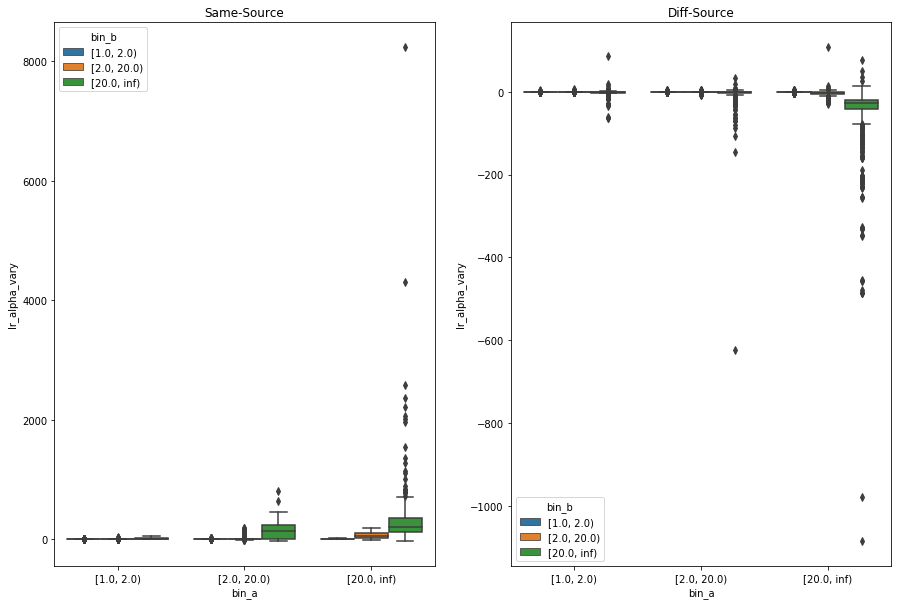

In [50]:
f, axes = plt.subplots(1, 2, figsize=(15,10))
sns.boxplot(y=score_func, x="bin_a", data=lr.loc[lr["same-src"] == True], hue="bin_b", ax=axes[0]).set_title("Same-Source")
sns.boxplot(y=score_func, x="bin_a", data=lr.loc[lr["same-src"] == False], hue="bin_b", ax=axes[1]).set_title("Diff-Source")
plt.show()


### SLR Methods

In [40]:
# merge & bin counts
slr = pd.merge(slr, cts_a, left_on="a", right_on="uid").drop(columns="uid")
slr = pd.merge(slr, cts_b, left_on="b", right_on="uid").drop(columns="uid")

splits = [1, 2, 20, float("inf")]
slr['bin_a'] = pd.cut(slr.n_a, bins=splits, right=False)
slr['bin_b'] = pd.cut(slr.n_b, bins=splits, right=False)

slr.head()

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user,same-src,label,n_a,n_b,bin_a,bin_b
0,1.0,1.0,0.357808,0.348943,0.351755,0.357431,0.300935,0.390402,0.398849,True,True,1,2,"[1.0, 2.0)","[2.0, 20.0)"
1,2310.0,1.0,0.248014,0.232466,0.223155,0.207772,0.169987,0.249149,0.235155,False,False,42,2,"[20.0, inf)","[2.0, 20.0)"
2,1.0,5679.0,0.582882,0.630841,0.608088,0.586331,0.987651,0.891648,0.846269,False,False,1,1,"[1.0, 2.0)","[1.0, 2.0)"
3,806.0,5679.0,0.400286,0.381784,0.399066,0.393618,0.379129,0.442828,0.432398,False,False,1,1,"[1.0, 2.0)","[1.0, 2.0)"
4,5679.0,5679.0,3.608145,4.000391,4.044515,4.015830,7.829822,8.272461,8.420063,True,True,1,1,"[1.0, 2.0)","[1.0, 2.0)"


In [41]:
score_func = 'ied_mn'
slr.groupby(['bin_a', 'bin_b']).apply(lambda x: calc_auc(x, score_func, 'same-src'))

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     0.686
             [2.0, 20.0)    0.742
             [20.0, inf)    0.523
[2.0, 20.0)  [1.0, 2.0)     0.733
             [2.0, 20.0)    0.842
             [20.0, inf)    0.938
[20.0, inf)  [1.0, 2.0)     0.808
             [2.0, 20.0)    0.957
             [20.0, inf)    0.981
dtype: object

In [42]:
slr.groupby(['bin_a', 'bin_b']).apply(lambda x: perf_measure(x['same-src'], x[score_func] > 1))

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     (0.461, 0.176)
             [2.0, 20.0)    (0.626, 0.236)
             [20.0, inf)    (0.333, 0.366)
[2.0, 20.0)  [1.0, 2.0)     (0.446, 0.114)
             [2.0, 20.0)    (0.723, 0.183)
             [20.0, inf)    (0.942, 0.269)
[20.0, inf)  [1.0, 2.0)     (0.562, 0.093)
             [2.0, 20.0)    (0.929, 0.128)
             [20.0, inf)    (0.996, 0.256)
dtype: object

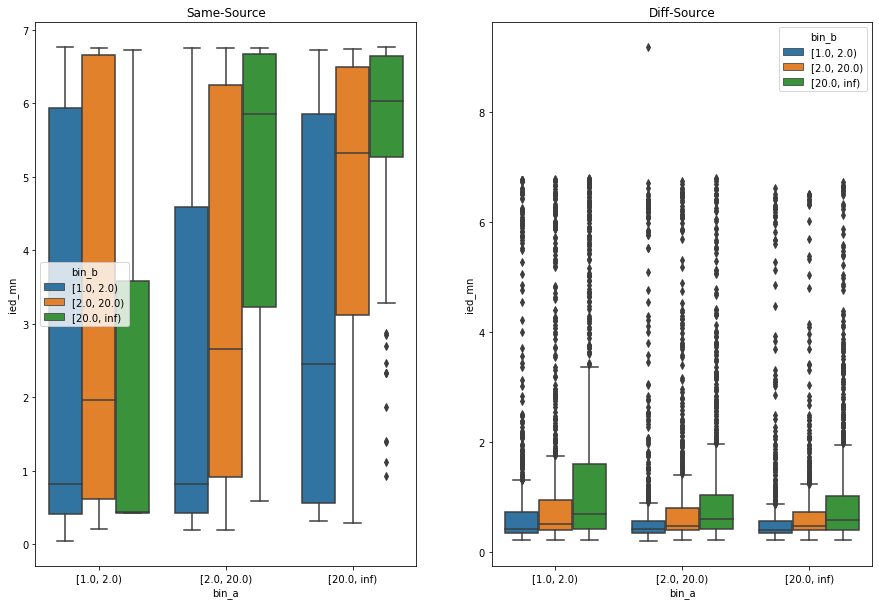

In [43]:
f, axes = plt.subplots(1, 2, figsize=(15,10))
sns.boxplot(y=score_func, x="bin_a", data=slr.loc[slr["same-src"] == True], hue="bin_b", ax=axes[0]).set_title("Same-Source")
sns.boxplot(y=score_func, x="bin_a", data=slr.loc[slr["same-src"] == False], hue="bin_b", ax=axes[1]).set_title("Diff-Source")
plt.show()

### CMP Methods

In [44]:
# merge & bin counts
cmp = pd.merge(cmp, cts_a, left_on="a", right_on="uid").drop(columns="uid")
cmp = pd.merge(cmp, cts_b, left_on="b", right_on="uid").drop(columns="uid")

splits = [1, 2, 20, float("inf")]
cmp['bin_a'] = pd.cut(cmp.n_a, bins=splits, right=False)
cmp['bin_b'] = pd.cut(cmp.n_b, bins=splits, right=False)

cmp.head()

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user,same-src,label,n_a,n_b,bin_a,bin_b
0,1.0,1.0,0.801511,0.804401,0.789398,0.786953,0.783841,0.726384,0.714826,True,False,1,2,"[1.0, 2.0)","[2.0, 20.0)"
1,2310.0,1.0,0.973189,0.967182,0.967405,0.968517,0.971966,0.959951,0.958060,False,True,42,2,"[20.0, inf)","[2.0, 20.0)"
2,1.0,5679.0,0.374097,0.360645,0.353974,0.354530,0.200556,0.197999,0.195553,False,True,1,1,"[1.0, 2.0)","[1.0, 2.0)"
3,806.0,5679.0,0.746581,0.749805,0.731903,0.732792,0.647059,0.613588,0.615145,False,True,1,1,"[1.0, 2.0)","[1.0, 2.0)"
4,5679.0,5679.0,0.061583,0.052357,0.050578,0.051356,0.023010,0.019453,0.019564,True,False,1,1,"[1.0, 2.0)","[1.0, 2.0)"


In [45]:
score_func = 'emd_wt_user'
cmp.groupby(['bin_a', 'bin_b']).apply(lambda x: calc_auc(x, score_func, 'label'))

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     0.692
             [2.0, 20.0)    0.719
             [20.0, inf)    0.566
[2.0, 20.0)  [1.0, 2.0)     0.751
             [2.0, 20.0)    0.818
             [20.0, inf)    0.920
[20.0, inf)  [1.0, 2.0)     0.806
             [2.0, 20.0)    0.946
             [20.0, inf)    0.970
dtype: object

In [46]:
cmp.groupby(['bin_a', 'bin_b']).apply(lambda x: perf_measure(x['same-src'], x[score_func] < 0.05))

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     (0.404, 0.132)
             [2.0, 20.0)    (0.362, 0.063)
             [20.0, inf)    (0.333, 0.038)
[2.0, 20.0)  [1.0, 2.0)     (0.421, 0.074)
             [2.0, 20.0)    (0.460, 0.040)
             [20.0, inf)    (0.674, 0.025)
[20.0, inf)  [1.0, 2.0)     (0.562, 0.046)
             [2.0, 20.0)    (0.695, 0.016)
             [20.0, inf)    (0.780, 0.017)
dtype: object

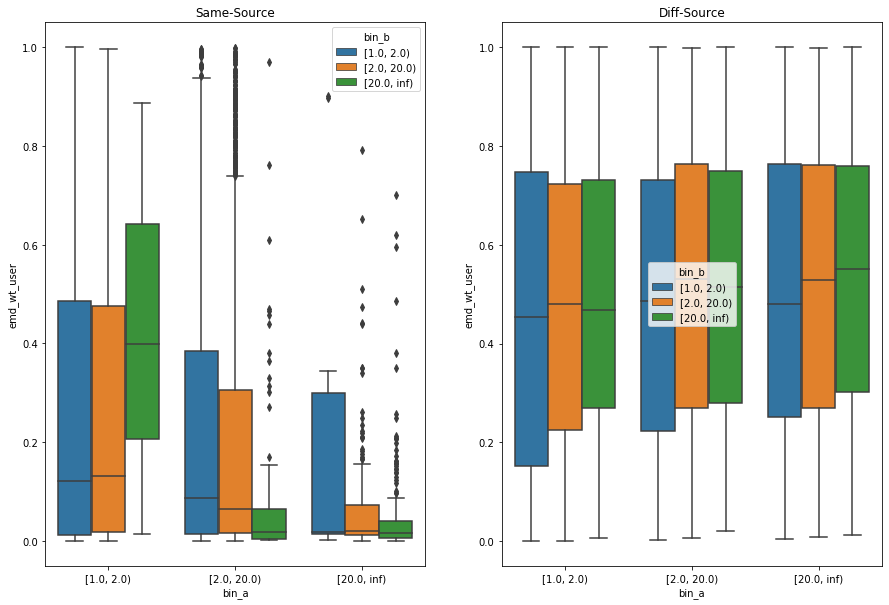

In [47]:
f, axes = plt.subplots(1, 2, figsize=(15,10))
sns.boxplot(y=score_func, x="bin_a", data=cmp.loc[cmp["same-src"] == True], hue="bin_b", ax=axes[0]).set_title("Same-Source")
sns.boxplot(y=score_func, x="bin_a", data=cmp.loc[cmp["same-src"] == False], hue="bin_b", ax=axes[1]).set_title("Diff-Source")
plt.show()